In [1]:
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize']=(20,10)
    import os,sys,cv2
    import tensorflow as tf
    import numpy as np
    print('doing something')
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    from pose_dataset import _get_dataflow_onlyread,CocoPose,read_image_url,pose_to_img,get_dataflow,get_dataflow_batch
    from pose_augmenter import set_network_input_wh, set_network_scale,get_augmented_image,check_network_input_wh
    print(check_network_input_wh())
    set_network_input_wh(368,368)
    print(check_network_input_wh())
    #set_network_input_wh(2560, 1440)
    set_network_scale(8)

    ## df = get_dataflow('/data/public/rw/coco/annotations', True, '/data/public/rw/coco/')
    ann_file = '../../data/raw/bee/dataset_raw/bee_annotation2018.json'
    ann_file = '../../data/raw/bee/dataset_raw/validation.json'
    is_train = False
    batch_size =3
    images = '../../data/raw/bee/dataset_raw/validation/'
    translation=True
    rotation=True
    scale=True
    output_shape = (368,368)
    crop_size = (368,368)
    mins=0.25#0.125
    maxs=0.7
    sigma=8
    mina=-np.pi/4
    maxa=np.pi/4
    #df = get_dataflow(ann_file, is_train,img_path=images,output_shape=crop_size,sigma=sigma,translation=translation,rotation=rotation,scale=scale,mins=mins,maxs=maxs,mina=mina,maxa=maxa)
  
    df = get_dataflow_batch(ann_file, is_train,batch_size,img_path=images,output_shape=crop_size,sigma=sigma,translation=translation,rotation=rotation,scale=scale,mins=mins,maxs=maxs,mina=mina,maxa=maxa)
    ##df = get_dataflow_batch('../../data/raw/bee/dataset_raw/bee_annotation2018.json', True,2, '../../data/raw/bee/dataset_raw/train/')
    ## df = get_dataflow('/root/coco/annotations', False, img_path='http://gpu-twg.kakaocdn.net/braincloud/COCO/')

    #from tensorpack.dataflow.common import TestDataSpeed
    ##TestDataSpeed(df).start()
    ##sys.exit(0)

    #with tf.Session() as sess:
    #    #df.reset_state()
    #    for idx, dp in enumerate(df.get_data()):
            
            #print('one more')
   #         pass 
            #        #plt.imshow(dp[0])
    #        #import pdb;pdb.set_trace()
    #        
    #        CocoPose.display_image(dp[0], dp[1].astype(np.float32), dp[2].astype(np.float32))
    #       #print(dp[0][1].shape, dp[0][2].shape)
    #   

doing something


Using TensorFlow backend.
[2020-02-15 21:58:42,813] [pose_dataset] [INFO] dataflow img_path=../../data/raw/bee/dataset_raw/validation/
[2020-02-15 21:58:42,826] [pose_dataset] [INFO] ../../data/raw/bee/dataset_raw/validation.json dataset 30


(368, 368, 8)
(368, 368, 8)
Creating images from ../../data/raw/bee/dataset_raw/validation.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[0215 21:58:42 @parallel.py:210] [MultiProcessRunner] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[0215 21:58:42 @argtools.py:146] WRN Starting a process with 'fork' method is not safe and may consume unnecessary extra CPU memory. Use 'forkserver/spawn' method (available after Py3.4) instead if you run into any issues. See https://docs.python.org/3/library/multiprocessing.html#contexts-and-start-methods
[0215 21:58:42 @parallel.py:210] [MultiProcessRunner] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.


In [2]:
def gen(df,batch_size,stages):
    batch_data =df.get_data()
    while True:
        batches_x, batches_x1, batches_x2, batches_y1, batches_y2 = \
            [None]*batch_size, [None]*batch_size, [None]*batch_size, \
            [None]*batch_size, [None]*batch_size
        # Img: Batch of images, *_weights:Weights obtained from mask
        # heat_maps : confidence maps for parts
        # Vector_maps: part affinity fields
        img,heat_weights,vec_weights, heat_maps,vector_maps  = tuple(next(df.get_data()))
        batch_x= img
        #vec_weights=np.ones(vector_maps.shape)
        #heat_weights=np.ones(heat_maps.shape)
        array=[vector_maps,heat_maps,
               vector_maps,heat_maps,
               vector_maps,heat_maps,
               vector_maps,heat_maps,
               vector_maps,heat_maps,
               vector_maps,heat_maps]
        #import pdb;pdb.set_trace()
        yield [img,vec_weights,  heat_weights], array[:stages*2]
def gen_val(df,batch_size):
    batch_data =df.get_data()
    while True:
        img,heat_weights,vec_weights = tuple(next(df.get_data()))
        #vec_weights=np.ones(vector_maps.shape)
        #heat_weights=np.ones(heat_maps.shape)
        #import pdb;pdb.set_trace()
        yield [img,vec_weights,  heat_weights]

In [ ]:
train_debug = gen(df,batch_size,2)
x,y = next(train_debug)

In [3]:
val_debug = gen_val(df,batch_size)

In [ ]:
batch_index=1
for i in range(10):
    x,y = next(train_debug)
dta_img = x[0][batch_index,:,:,:]
plt.imshow(dta_img[:,:,:]/256)

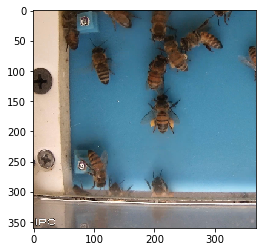

In [4]:
batch_index=1
for i in range(10):
    x = next(val_debug)
dta_img = x[0][batch_index,:,:,:]
plt.imshow(dta_img[:,:,:]/256)

In [6]:
dta_img.shape

(360, 368, 3)

In [ ]:
from skimage.util import img_as_ubyte,img_as_uint

In [ ]:
np.max(dta_img)

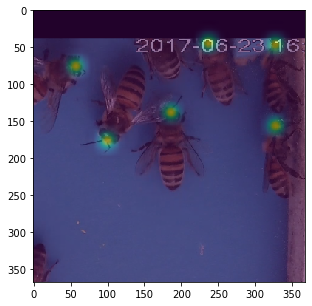

In [6]:


plt.rcParams['figure.figsize'] =5,5

x,y = next(train_debug)
dta_img = x[0][batch_index,:,:,:]
body_part=1

heatmap = cv2.resize(np.array(y[1][batch_index,:, :, body_part],dtype=np.float), (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
#mask_img =np.ones(heatmap.shape)
mask_img = x[2]
mask_img = cv2.resize(mask_img[:,:, 2], (0,0), fx=8, fy=8, interpolation=cv2.INTER_NEAREST)      
plt.imshow(dta_img[:,:,:]/256)
plt.imshow(heatmap[:,:], alpha=.5)
#plt.imshow(mask_img,alpha=0.3)

In [ ]:
dta_img.dtype

In [ ]:
x,y = next(train_debug)
(y[1][:, :, body_part].dtype,
y[1][:, :, body_part].shape,
y[1][:, :, body_part].min(),
y[1][:, :, body_part].max(),
)

In [ ]:
x,y = next(train_debug)
(y[2][:, :, body_part].dtype,
y[2][:, :, body_part].shape,
y[2][:, :, body_part].min(),
y[2][:, :, body_part].max())

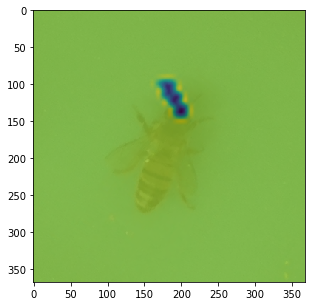

In [14]:
batch_index = 0
paf_idx = 7
#x,y = next(train_debug)
dta_img = x[0][batch_index,:,:,:]
plt.imshow(dta_img[:,:,[0,1,2]]/256)

paf = cv2.resize(np.array(y[2][batch_index, :, :, paf_idx],dtype=np.float), (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)


plt.imshow(paf[:,:], alpha=.7)

In [ ]:
mask_img[:,:, 2].shape

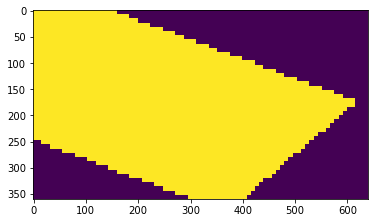

In [33]:
mask_img = x[2][batch_index,:,:,:]

mask_img = cv2.resize(mask_img[:,:, 2], (0,0), fx=8, fy=8, interpolation=cv2.INTER_NEAREST)


plt.imshow(mask_img)

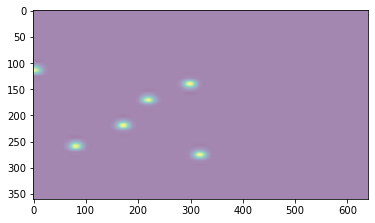

In [ ]:
from skimage.transform import AffineTransform, warp, warp_coords, swirl
from math import cos, sin
import numpy as np
import random
from tensorpack.dataflow.common import BatchData, MapData, MapDataComponent
ds = CocoPose('../../data/raw/bee/dataset_raw/bee_annotation2018.json',
              '../../data/raw/bee/dataset_raw/train/',True,
             output_shape=(1440//1,2560//1),
             translation=False,scale=False,rotation=False,maxs=1, ilumination=0.0)

ds = MapData(ds,read_image_url)
ds = MapDataComponent(ds, get_augmented_image)
gen= ds.get_data()
meta = next(gen)[0]

In [ ]:
thoraxes = [ p[2] for p in meta.joint_list ]
im = meta.img_org#cv2.imread('../../data/raw/bee/dataset_raw/train/000001706210.jpg')

In [ ]:
id=0
cx,cy = thoraxes[id]

plt.imshow(im)
for t in thoraxes:
    plt.plot(t[0],t[1],'*',color='y')
plt.plot(cx,cy,'ro')

In [ ]:
#cx,cy = random.choice(thoraxes)


In [ ]:
a=np.random.uniform(-1,1)*np.pi
s=np.random.uniform(0.25,2.0)

h=368
w=368
s=1/7

output_shape=(h,w)

tform = AffineTransform(translation = (-w/2,-h/2))
tform += AffineTransform(rotation=a)
tform += AffineTransform(scale=(1/s,1/s))
tform += AffineTransform(translation = (cx,cy))
#

#tform += AffineTransform(translation = (cx//2,cy//2))#


In [ ]:
im_out = warp(im,tform,output_shape=output_shape,mode='constant')

plt.imshow(im_out)

# Testing parameters for Augmentation

In [ ]:
from tensorpack.dataflow.common import BatchData, MapData, MapDataComponent
skeleton = list(zip([1,1,3,2,2],[2,3,2,4,5]))
#list(zip([2,2,4,3,3],[3,4,3,1,5]))
ds = CocoPose('../../data/raw/bee/dataset_raw/bee_annotation2018.json',
              '../../data/raw/bee/dataset_raw/train/',True,
             output_shape=(1440//1,2560//1),skeleton=skeleton,
             translation=True,scale=True,rotation=True,maxs=1, ilumination=0.0)

ds = MapData(ds,read_image_url)
ds = MapDataComponent(ds, get_augmented_image)
gen= ds.get_data()
meta = next(gen)[0]

In [ ]:
meta = next(gen)[0]
plt.imshow(meta.img)
#for jl in meta.joint_list:
#    plt.plot(jl[2][0],jl[2][1],'o')

In [ ]:
plt.imshow(meta.mask_miss_out.astype('int8'))


In [ ]:
meta.mask_all_out.shape

In [ ]:
plt.imshow(new)

In [20]:
meta.mask_all_out.astype('int8')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

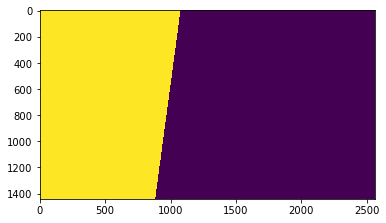

In [26]:
plt.imshow(meta.mask_miss_out.astype('int8'))

In [21]:
plt.imshow(meta.mask_miss_out.astype('int8'))

In [23]:
new_mask =cv2.resize(mask,(368,368),interpolation=cv2.INTER_NEAREST)

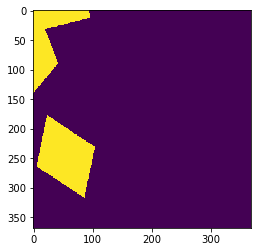

In [24]:
plt.imshow(new_mask)

In [84]:
#resized = cv2.resize(meta.img,(meta.output_shape[1]//4,meta.output_shape[0]//4),interpolation=cv2.INTER_CUBIC)
#plt.imshow(resized)

In [40]:
meta.skeleton

[(2, 4), (2, 5), (1, 3), (2, 3)]

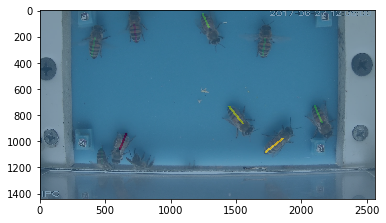

In [4]:
#meta = next(gen)[0]
vmp = meta.get_vectormap(target_size=(meta.output_shape[1],meta.output_shape[0]))
batch = np.repeat(vmp[np.newaxis,:,:,:], 2, axis=0)
plt.imshow(meta.img)
plt.imshow(np.array(vmp[:,:,2],dtype=np.float),alpha=0.6)#np.array(vmp[:,:,1],dtype=np.float),alpha=0.6)

random_tform_params: output_shape and maxs too large, may not fit inside input image


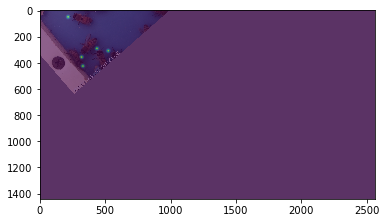

In [62]:
meta = next(gen)[0]
vmp = meta.get_heatmap(target_size=(meta.output_shape[1],meta.output_shape[0]))
batch = np.repeat(vmp[np.newaxis,:,:,:], 2, axis=0)
plt.imshow(meta.img)
plt.imshow(np.array(vmp[:,:,0],dtype=np.float),alpha=0.6)#np.array(vmp[:,:,1],dtype=np.float),alpha=0.6)

In [55]:
meta.skeleton

AttributeError: 'CocoMetadata' object has no attribute 'skeleton'

In [29]:
hmp = meta.get_heatmap(target_size=(meta.output_shape[1]//4, meta.output_shape[0]//4))
plt.imshow(resized)
#hmp_resized = cv2.resize(hmp,(meta.output_shape[1]//4,meta.output_shape[0]//4),interpolation=cv2.INTER_CUBIC)
plt.imshow(np.array(hmp[:,:,1],dtype=np.float),alpha=0.6)

NameError: name 'resized' is not defined

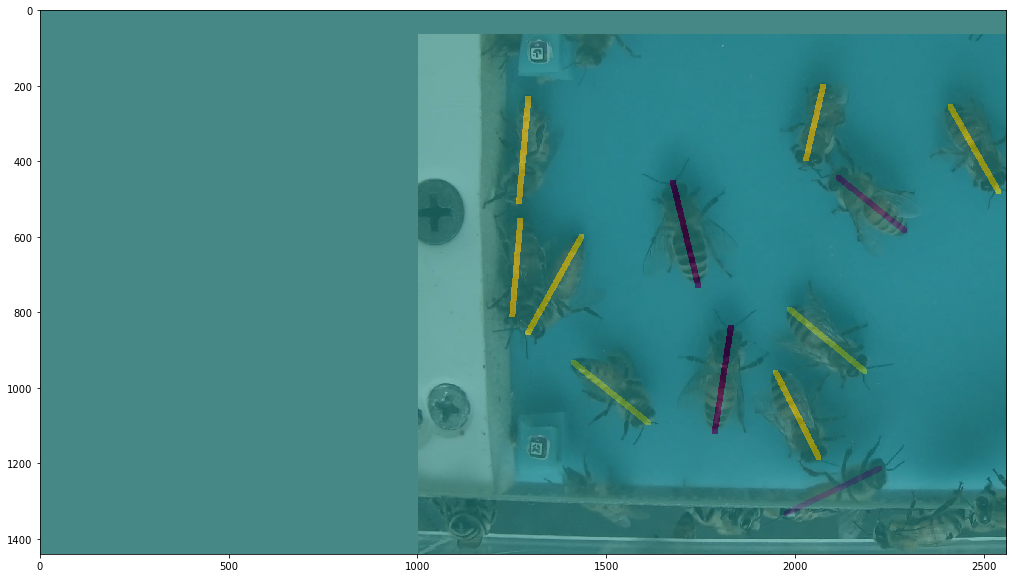

In [7]:
vmp = meta.get_vectormap(target_size=(meta.output_shape[1],meta.output_shape[0]))
plt.imshow(meta.img)
plt.imshow(np.array(vmp[:,:,1],dtype=np.float),alpha=0.6)

In [8]:
meta.output_shape

(1440, 2560)

In [196]:
meta.joint_list[0]

array([[  903.77197756,   -50.83749124],
       [  737.38757677,  -225.97238546],
       [  783.51597991,  -164.00327684],
       [  682.02129846,  -201.67063189],
       [  786.00252252,  -273.39165422],
       [-2524.85520574,   967.4294865 ]])

In [164]:
np.array(hmp[:,:,0],dtype=np.float).shape

(720, 1280)

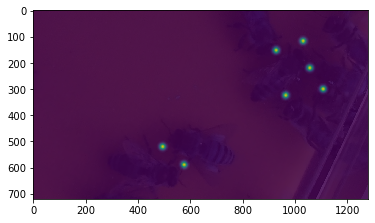

In [17]:
pose = pose_to_img([new_meta])

NameError: name 'new_meta' is not defined

In [ ]:
hmp = meta[1]

In [ ]:
import numpy as np
plt.imshow(CocoPose.get_bgimg(meta[0],(368,368)))
plt.imshow(np.array(hmp[:,:,2],dtype=np.float32),alpha=0.4)

In [2]:
df = _get('../../data/raw/bee/dataset_raw/bee_annotation2018.json', True, '../../data/raw/bee/dataset_raw/train/')

[2019-08-08 14:22:35,415] [pose_dataset] [INFO] ../../data/raw/bee/dataset_raw/bee_annotation2018.json dataset 135


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
[0808 14:22:35 @parallel.py:210] [MultiProcessRunner] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[0808 14:22:35 @argtools.py:146] WRN "import prctl" failed! Install python-prctl so that processes can be cleaned with guarantee.


In [3]:
gen= df.get_data()
meta = next(gen)

KeyboardInterrupt: 

<generator object MapData.__iter__ at 0x7f02f04c6ca8>